In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import random
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils import shuffle
from skmultiflow.drift_detection.adwin import ADWIN
import math

cls <class 'pathlib.Path'>
os name nt
self C:\Users\Terry\Anaconda3\envs\py36\lib\site-packages\matplotlib\__init__.py
normal_accessor
normal_accessor
pathobj C:\Users\Terry\Anaconda3\envs\py36\lib\site-packages\matplotlib\mpl-data
cls <class 'pathlib.Path'>
os name nt
self C:\Users\Terry\Anaconda3\envs\py36\lib\site-packages\matplotlib\mpl-data\matplotlibrc
normal_accessor
cls <class 'pathlib.Path'>
os name nt
self .
normal_accessor
cls <class 'pathlib.Path'>
os name nt
self C:\Users\Terry
normal_accessor
normal_accessor
cls <class 'pathlib.Path'>
os name nt
self .
normal_accessor
cls <class 'pathlib.Path'>
os name nt
self C:\Users\Terry
normal_accessor
normal_accessor
pathobj C:\Users\Terry\.matplotlib
pathobj C:\Users\Terry\.matplotlib
pathobj C:\Users\Terry\.matplotlib
cls <class 'pathlib.Path'>
os name nt
self .
normal_accessor
cls <class 'pathlib.Path'>
os name nt
self C:\Users\Terry
normal_accessor
normal_accessor
cls <class 'pathlib.Path'>
os name nt
self .
normal_accessor
cls 

# iForest ADWIN

In [2]:
class Node:
    def __init__(self,internal=True,left=None,right=None,sAtt=None,sVal=None,size=None):
        self.internal = internal
        self.size = size
        self.left = left
        self.right = right
        self.sAtt = sAtt
        self.sVal = sVal
        return
            

In [3]:
def c(n):
#     print('3333',n)
    return 2*H(n-1)-(2*(n-1)/n)

def H(i):
    return math.log(i)+0.5772156649

In [4]:
class iTree:
    def __init__(self,X,e,l,X_cati=None):
        """
        INPUTS:
        X: input data
        e: current tree height
        l: height limit

        OUTPUT:
        """
        self.X = X
        self.l = l
        self.root = self.build(X,e,l,X_cati)
        return

    def build(self,X,e,l,X_cati=None):
#         print('e:',e,'l：',l)
        if e>=l or len(X)<=1:
#             print(e)
            return Node(internal=False,size=len(X))
        else:
            q = random.randint(0,len(X[0])-1)
            if X_cati and X_cati[q]:
                p = random.choice(list(set(X[:,q])))
                Xl = X[X[:,q]==p]
                Xr = X[X[:,q]!=p]
                return Node(internal=True,
                            left=self.build(Xl,e+1,l,X_cati),
                            right=self.build(Xr,e+1,l,X_cati),
                            sAtt=q,
                            sVal=p)
            else:
                p = random.uniform(min(X[:,q]),max(X[:,q]))
                Xl = X[X[:,q]<p]
                Xr = X[X[:,q]>=p]
                return Node(internal=True,
                            left=self.build(Xl,e+1,l,X_cati),
                            right=self.build(Xr,e+1,l,X_cati),
                            sAtt=q,
                            sVal=p)
            
    def pathLength(self,x,N=None,e=0,X_cati=None):
        """
        INPUTS:
        x: an instance
        N: a Node in the iTree
        e: current path length
        """
        if not N:
            N = self.root
        if not N.internal:
            if N.size>1:
#                 print(1)
                return e+(N.size>1)*c(N.size)
            else:
#                 print(0)
                return e
        a = N.sAtt
        if X_cati and X_cati[a]:
            if x[a] == N.sVal:
                return self.pathLength(x,N.left,e+1,X_cati)
            else:
                return self.pathLength(x,N.right,e+1,X_cati)
        else:
            if x[a] < N.sVal:
                return self.pathLength(x,N.left,e+1,X_cati)
            else:
                return self.pathLength(x,N.right,e+1,X_cati)
        
    def draw(self):
        if len(self.X[0])!=2:
            print('iTree.draw() function only support 2D data')
            return
        plt.figure()
        plt.scatter(self.X[:,0],self.X[:,1])
        limits = [[min(self.X[:,0]),max(self.X[:,0])],[min(self.X[:,1]),max(self.X[:,1])]]
        self._helper(self.root,limits)
                
    def _helper(self,node,limits):
        if not node.internal:
            return
        att = node.sAtt
        val = node.sVal
        point1 = [(1-att)*val+att*limits[1-att][0],att*val+(1-att)*limits[1-att][0]]
        point2 = [(1-att)*val+att*limits[1-att][1],att*val+(1-att)*limits[1-att][1]]
        plt.plot([point1[0],point2[0]],[point1[1],point2[1]])
        limitL = [[limits[0][0],(1-att)*val+att*limits[0][1]],[limits[1][0],(1-att)*limits[1][1]+att*val]]
        limitR = [[(1-att)*val+att*limits[0][0],limits[0][1]],[(1-att)*limits[1][0]+att*val,limits[1][1]]]
        self._helper(node.left,limitL)
        self._helper(node.right,limitR)

2

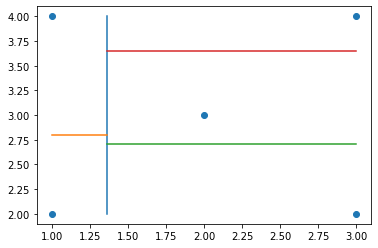

In [5]:
X = np.array([[1,2],[2,3],[3,4],[1,4],[3,2]])
tree = iTree(X,0,3)
tree.draw()
tree.pathLength([1,5])


In [6]:
import math
import random
class iForest:
    def __init__(self,X,t,phi,X_cati=None):
        """
        INPUTS:
        X: input data
        X_type: list of data type in each dimension of X
        t: number of trees
        phi: subsampling size
        
        OUTPUT:
        Forest: a set of t iTrees
        """
        self.size = t
        self.n = phi
        self.forest = []
        self._Train(X,t,phi,X_cati)
        return
        
    def _Train(self,X,t,phi,X_cati):
        # l: height limit of iTrees
        l = math.ceil(math.log2(phi))
#         l = phi/2
#         l = min(math.ceil(math.log2(phi))*2,phi/2)
        for i in range(t):
            # X_prime: subsample of X, used for training the ith iTree
            X_prime = X[np.random.choice(X.shape[0], phi, replace=False), :]
#             print(X_prime.shape)
            self.forest.append(iTree(X_prime,0,l,X_cati))
    
    def predict(self,x):
        h_sum = 0
        for i in range(self.size):
#             print(self.forest[i].pathLength(x))
            h_sum += self.forest[i].pathLength(x)
        E = h_sum/self.size
#         print('E',E)
#         print('c',c(self.n))
        return 2**(-E/c(self.n))
        

In [7]:
class ADWIN1:
    def __init__(self,delta=0.02):
        self.W = []
        self.delta = delta
        self.change = False
        
    
    def add_element(self,x):
        self.change = False
        self.W.append(x)
        while len(self.W)>1 and self.driftTest():
            self.change = True
            del self.W[0]
            
    def detected_change(self):
        return self.change
            
    def driftTest(self):
        for i in range(1,len(self.W)-1):
            W0 = self.W[:i]
            W1 = self.W[i:]
            n0 = len(W0)
            n1 = len(W1)
            n = len(self.W)
#             print('n0',n0,'n1',n1)
            m = 1/(1/n0+1/n1)
            delta_prime = self.delta/n
            epsilon_cut = (1/(2*m)*np.log(4/delta_prime))**(1/2)
            mu0 = np.mean(W0)
            mu1 = np.mean(W1)
            if abs(mu0-mu1)>=epsilon_cut:
                return True
        return False
            
        

In [8]:
class MADWIN:
    def __init__(self,delta=0.02,min_win_size=50,max_size=250):
        self.W = []
        self.delta = delta
        self.min_win_size = min_win_size
        self.max_size = max_size
        self.change = False
        self.min_i = 0
        self.max_i = 0
        
    
    def add_element(self,x):
        if len(self.W)>=self.max_size:
            del self.W[0]
            self.min_i += 1
        self.change = False
        self.W.append(x)
        self.max_i += 1
        while len(self.W)>1 and self.driftTest():
            self.change = True
            del self.W[-1]
            self.max_i -= 1
            
    def detected_change(self):
        ans = self.change
        self.change = False
        return ans
            
    def driftTest(self):
        for i in range(self.min_win_size,len(self.W)-self.min_win_size):
            W0 = self.W[:i]
            W1 = self.W[i:]
            n0 = len(W0)
            n1 = len(W1)
            n = len(self.W)
#             print('n0',n0,'n1',n1)
            m = 1/(1/n0+1/n1)
            delta_prime = self.delta/n
            epsilon_cut = (1/(2*m)*np.log(4/delta_prime))**(1/2)
            mu0 = np.mean(W0)
            mu1 = np.mean(W1)
            if abs(mu0-mu1)>=epsilon_cut:
                return True
        return False
            
        

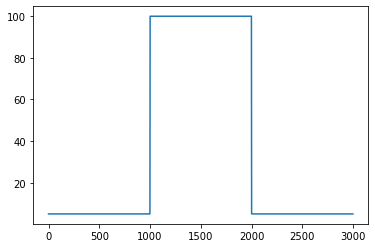

concept drift 1000 100
concept drift 1001 100
concept drift 1002 100
concept drift 1003 100
concept drift 1004 100
concept drift 1005 100
concept drift 1006 100
concept drift 1007 100
concept drift 1008 100
concept drift 1009 100
concept drift 1010 100
concept drift 1011 100
concept drift 1012 100
concept drift 1013 100
concept drift 1014 100
concept drift 1015 100
concept drift 1016 100
concept drift 1017 100
concept drift 1018 100
concept drift 1019 100
concept drift 1020 100
concept drift 1021 100
concept drift 1022 100
concept drift 1023 100
concept drift 1024 100
concept drift 1025 100
concept drift 1026 100
concept drift 1027 100
concept drift 1028 100
concept drift 1029 100
concept drift 1030 100
concept drift 1031 100
concept drift 1032 100
concept drift 1033 100
concept drift 1034 100
concept drift 1035 100
concept drift 1036 100
concept drift 1037 100
concept drift 1038 100
concept drift 1039 100
concept drift 1040 100
concept drift 1041 100
concept drift 1042 100
concept dri

concept drift 1360 100
concept drift 1361 100
concept drift 1362 100
concept drift 1363 100
concept drift 1364 100
concept drift 1365 100
concept drift 1366 100
concept drift 1367 100
concept drift 1368 100
concept drift 1369 100
concept drift 1370 100
concept drift 1371 100
concept drift 1372 100
concept drift 1373 100
concept drift 1374 100
concept drift 1375 100
concept drift 1376 100
concept drift 1377 100
concept drift 1378 100
concept drift 1379 100
concept drift 1380 100
concept drift 1381 100
concept drift 1382 100
concept drift 1383 100
concept drift 1384 100
concept drift 1385 100
concept drift 1386 100
concept drift 1387 100
concept drift 1388 100
concept drift 1389 100
concept drift 1390 100
concept drift 1391 100
concept drift 1392 100
concept drift 1393 100
concept drift 1394 100
concept drift 1395 100
concept drift 1396 100
concept drift 1397 100
concept drift 1398 100
concept drift 1399 100
concept drift 1400 100
concept drift 1401 100
concept drift 1402 100
concept dri

concept drift 1738 100
concept drift 1739 100
concept drift 1740 100
concept drift 1741 100
concept drift 1742 100
concept drift 1743 100
concept drift 1744 100
concept drift 1745 100
concept drift 1746 100
concept drift 1747 100
concept drift 1748 100
concept drift 1749 100
concept drift 1750 100
concept drift 1751 100
concept drift 1752 100
concept drift 1753 100
concept drift 1754 100
concept drift 1755 100
concept drift 1756 100
concept drift 1757 100
concept drift 1758 100
concept drift 1759 100
concept drift 1760 100
concept drift 1761 100
concept drift 1762 100
concept drift 1763 100
concept drift 1764 100
concept drift 1765 100
concept drift 1766 100
concept drift 1767 100
concept drift 1768 100
concept drift 1769 100
concept drift 1770 100
concept drift 1771 100
concept drift 1772 100
concept drift 1773 100
concept drift 1774 100
concept drift 1775 100
concept drift 1776 100
concept drift 1777 100
concept drift 1778 100
concept drift 1779 100
concept drift 1780 100
concept dri

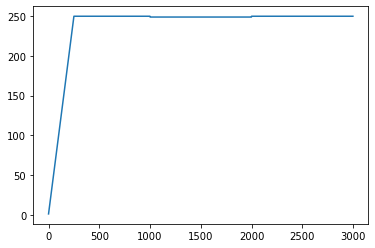

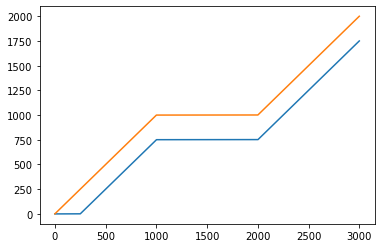

In [9]:
stream = [5]*1000+[100]*1000+[5]*1000
plt.figure()
plt.plot(stream)
plt.show()
madwin = MADWIN()
w = []
max_i = []
min_i = []
for i in range(len(stream)):
    x = stream[i]
    madwin.add_element(x)
    w.append(len(madwin.W))
    max_i.append(madwin.max_i)
    min_i.append(madwin.min_i)
    if madwin.detected_change():
        print('concept drift',i,x)
plt.figure()
plt.plot(w)
plt.show()

plt.figure()
plt.plot(min_i)
plt.plot(max_i)
plt.show()

In [10]:
class Detector:
    def __init__(self,t,phi,delta=0.02,min_win_size=50):
        """
        INPUTS:
        t: iforest number of trees
        phi: iforest subsampling size
        delta: adwin threshold
        min_win_size: adwin minimal window size
        """
        self.t = t
        self.phi = phi
        self.delta = delta
        self.selector = VarianceThreshold()
        self.madwin = MADWIN(delta=self.delta)
        self.adwin = ADWIN(delta=self.delta)
        self.feature_filter = None
        self.iforest = None
        return
    
    def train(self,X):
        X_prime = self.selector.fit_transform(X)
        self.feature_filter = self.selector.get_support()
        self.iforest = iForest(X_prime, self.t, self.phi)
        return
    
    def predict(self,x):
        x = x.reshape((1,-1))
        xp = self.selector.transform(x)
        xp = xp.reshape((-1,))
        s = self.iforest.predict(xp)
        self.madwin.add_element(s*2)
        self.adwin.add_element(s)
        adwins = 0
        if self.adwin.detected_change():
            adwins = 1
        if self.madwin.detected_change():
            return -1, adwins
        return s, adwins

In [39]:
class algorithm:
    def __init__(self,e,window_size,t,phi,delta=0.02,min_win_size=50,thresh=0.7):
        """
        INPUT:
        e: number of detectors
        window_size: buffer size
        t: iforest number of trees
        phi: iforest subsampling size
        delta: adwin threshold
        min_win_size: adwin minimal window size
        thresh: abnormal threshold
        """
        self.e = e
        self.window_size = window_size
        self.t = t
        self.phi = phi
        self.delta = delta
        self.thresh = thresh
        self.min_win_size = min_win_size
        self.selector = VarianceThreshold()
        self.previous_window = []
        self.current_window = []
        self.ensemble = []
        return
    
    def predict(self,x):
        output = []
        var = []
        if len(self.current_window)==self.window_size:
            self.previous_window = self.current_window
            self.current_window = []
            # feature selection:
            self.selector.fit(self.previous_window)
            feature_filter = self.selector.get_support()
            if self._feature_drift_detection(feature_filter) or len(self.ensemble)==0:
                # feature drift occurs OR no existing detector in ensemble
                detector = Detector(self.t,self.phi,self.delta,self.min_win_size)
#                 print('Add new detector because feature drift')
                detector.train(self.previous_window)
                if len(self.ensemble)>=self.e:
                    del self.ensemble[0]
                self.ensemble.append(detector)
                output = [-1]*len(self.previous_window)
                var = [-1]*len(self.previous_window)
                return output,var
            else:
                for sample in self.previous_window:
                    scores = np.zeros((len(self.ensemble),))
                    for i in range(len(self.ensemble)):
                        detector = self.ensemble[i]
                        if np.array_equal(detector.feature_filter,feature_filter):
                            s,_ = detector.predict(sample)
                            scores[i] = s
                    var.append(scores)
                    valid_scores = scores[scores>0]
                    if len(valid_scores)>0:
                        score = np.mean(valid_scores)
                        if score>self.thresh:
                            output.append(0)
                        else:
                            output.append(1)
                    else:
                        detector = Detector(self.t,self.phi,self.delta,self.min_win_size)
#                         print('Add new detector because concept drift')
#                         print('scores',scores)
                        detector.train(self.previous_window)
                        if len(self.ensemble)>=self.e:
                            del self.ensemble[0]
                        self.ensemble.append(detector)
                        output = [-1]*len(self.previous_window)
                        var = [-1]*len(self.previous_window)
                        return output,var
        self.current_window.append(x)
        return output,var
        
    def _feature_drift_detection(self,feature_filter):
        for detector in self.ensemble:
            if np.array_equal(detector.feature_filter,feature_filter):
                return False
        return True
        

In [12]:
class iForestADWIN:
    def __init__(self,train_size,t,phi,X_cati=None,thresh=0.7,text=False,delta=0.02):
        self.i = 0
        self.train_size = train_size
        self.t = t
        self.phi = phi
        self.X_cati = X_cati
        self.forest = None
        self.delta = delta
        self.adwin = ADWIN(delta=delta)
        self.train_data = []
        self.score = []
        self.prediction = []
        self.train_state = True 
#         self.anomaly = 0
        self.text = text
        self.thresh = thresh
        self.feature_filter = None
        return
    
    def train(self):
        self.train_data = np.array(self.train_data)
        selector = VarianceThreshold()
        self.train_data = selector.fit_transform(self.train_data)
#         print(self.train_data.shape)
        self.forest = iForest(self.train_data, self.t, self.phi, self.X_cati)
#         return
        return selector.get_support()
    
    def retrain(self):
        self.forest = None
        self.adwin = ADWIN(delta=self.delta)
        self.train_data = []
        self.train_state = True
        return
    
    def add_element(self,x):
        if len(self.train_data)<self.train_size:
            self.score.append(-1)
            self.prediction.append(-1)
            self.train_data.append(x)
        elif len(self.train_data)==self.train_size and self.train_state:
            self.score.append(-1)
            self.prediction.append(-1)
            self.feature_filter = self.train()
            self.train_state = False
        else:
            x = [x[i] for i in range(len(x)) if self.feature_filter[i]]
            print(x)
            predict = self.forest.predict(x)
#             print(predict)
            self.score.append(predict)
            self.adwin.add_element(predict*4)
            if self.adwin.detected_change():
                if self.text:
                    print('Change detected:',x,'index',self.i)
                self.prediction.append(-1)
                self.retrain()
            else:
                if predict>self.thresh:
                    self.prediction.append(0)
                    self.anomaly += 1
                    if self.text:
                        print('Anomaly detected:',x,'index',self.i)
                else:
                    self.prediction.append(1)
        self.i += 1
        return
        
        

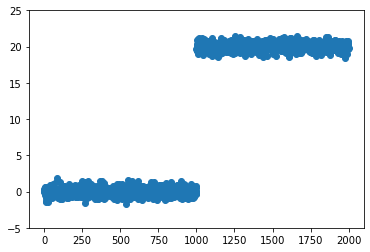

(2000, 1)


In [13]:
mean = [0,20,0,20]
var = [.5,.5,.5,.5]
X = np.array([])
for i in range(2):
    X = np.concatenate((X,np.random.normal(mean[i],var[i],1000)),axis=0)

X[500]=70
X[1500]=90
# X[2500]=20
# X[3500]=0
    
plt.figure()
plt.scatter(range(len(X)),X)
plt.ylim(-5,25)
plt.show()
stream = X.reshape((-1,1))
print(stream.shape)

In [145]:
dataset = ['raw_data/shuttle.txt',
           'raw_data/smtp.txt',
           'raw_data/pima.txt',
           'raw_data/satellite.txt',
           'raw_data/smtp_http.txt',
           'raw_data/shuttle.txt',
           'raw_data/shuttle.txt']

In [146]:
a = np.loadtxt(dataset[1])
stream = a[:,:-1]
label = a[:,-1]
label = 1-label
print(stream.shape)

(95156, 3)


In [14]:
def segment_generate(means,variances,length,biases,ratio):
    stream = np.zeros((len(means),length))
    indexs = np.random.choice(length,size=int(length*ratio),replace=False)
    label = np.ones((length,))
    for i in indexs:
        label[i] = 0
    for d in range(len(means)):
        mean = means[d]
        var = variances[d]
        bias = biases[d]
        stream[d] = np.random.normal(mean,var,length)
        for i in indexs:
            stream[d,i] = np.random.normal(mean+bias,var)
    return stream.T,label

In [42]:
def evaluation(prediction,label):
    TP=0
    TN=0
    FP=0
    FN=0
    for i in range(len(label)):
        if prediction[i] != -1:
            if prediction[i] and label[i]:
                TP += 1
            elif prediction[i] and not label[i]:
                FP += 1
            elif not prediction[i] and label[i]:
                FN += 1
            else:
                TN += 1
    ACC = (TP+TN)/(TP+TN+FP+FN)
    Precision = TP/(TP+FP) if TP>0 else 0
    Recall = TP/(TP+FN) if TP>0 else 0
    F1 = 2*Precision*Recall/(Precision+Recall) if Precision>0 and Recall>0 else 0
    FPR = FP/(FP+TN) if FP>0 else 0
    TPR = TP/(TP+FN) if TP>0 else 0
    print('TP:',TP,'TN:',TN,'FP:',FP,'FN:',FN)
    print('ACC:',ACC,'Precision:',Precision,'Recall:',Recall,'F1:',F1)
    print('FPR:',FPR,'TPR:',TPR)
    return np.array([TP,TN,FP,FN,ACC,Precision,Recall,F1,FPR,TPR])

(0, 5)
(3000, 5)
(3000,)


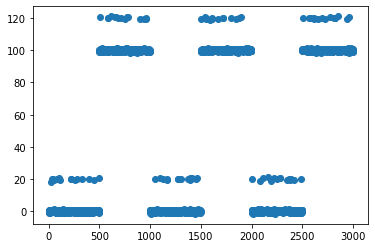

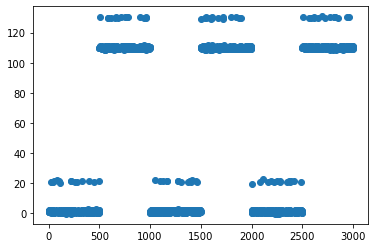

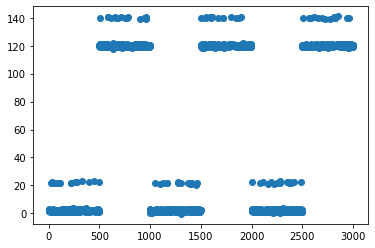

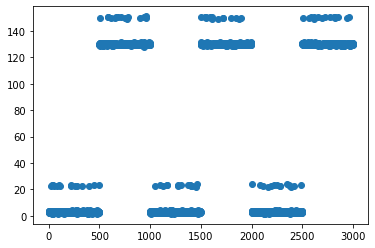

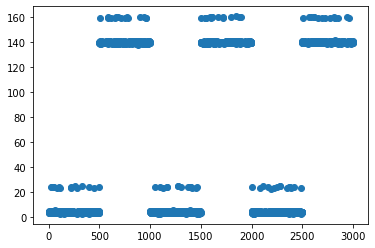

In [49]:
means = [[0,1,2,3,4],[100,110,120,130,140]]
variances = [[.5,.5,.5,.5,.5],[.5,.5,.5,.5,.5]]
length = 500
biases = [[20]*5,[20]*5]
stream = np.array([]).reshape((-1,5))
label = np.array([])
print(stream.shape)
for i in range(6):
    s,l = segment_generate(means[i%2],variances[i%2],length,biases[i%2],0.03)
    stream = np.concatenate((stream,s),axis=0)
    label = np.concatenate((label,l),axis=0)
print(stream.shape)
print(label.shape)
for d in range(len(stream[1])):
    plt.figure()
    plt.scatter(range(length*6),stream[:,d])
    plt.show()

In [ ]:
# window_size_list = list(range(10,1000,50))
# t_list = list(range(10,100,20))
# phi_list = list(range(int(window_size/10),window_size,int(window_size/10)))
# thresh_list = [0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75]

window_size_list = [30,50,100,500]
t_list = [10,25,50,100]
phi_list = [0.1,0.25,0.5,0.7,0.9]
thresh_list = [0.45,0.5,0.55,0.6,0.65]

results = np.zeros((len(window_size_list),len(t_list),len(phi_list),len(thresh_list),10))

for aa in range(len(window_size_list)):
    window_size = window_size_list[aa]
    for bb in range(len(t_list)):
        t = t_list[bb]
        for cc in range(len(phi_list)):
            phi = int(phi_list[cc]*window_size)
            for dd in range(len(thresh_list)):
                thresh = thresh_list[dd]

#                 madwin_len = [[],[],[]]

#                 max_i = [[],[],[]]
#                 min_i = [[],[],[]]
                
                print('*'*10)
                print('window_size:',window_size)
                print('t:',t)
                print('phi:',phi)
                print('thresh:',thresh)
                detector = algorithm(e=10,
                                     window_size=window_size,
                                     t=t,
                                     phi=phi,
                                     delta=0.02,
                                     min_win_size=5,
                                     thresh=thresh)
                prediction = []
                scores = []
#                 e_num = []
                tic = time.time()
                for i in range(len(stream)):
                    x = stream[i]
                    output,var = detector.predict(x)
                    prediction += output
#                     e_num.append(len(detector.ensemble))
                    print(str(aa*len(t_list)*len(phi_list)*len(thresh_list)
                              +bb*len(phi_list)*len(thresh_list)
                              +cc*len(thresh_list)
                              +dd)+'/'
                            +str(len(window_size_list)
                               *len(t_list)
                               *len(phi_list)
                               *len(thresh_list))
                          +' '
                          +str(i)+'/'+str(len(stream)),end='\r')
                toc = time.time()
                print('time used:'+str(toc-tic))
#                     for e in range(len(detector.ensemble)):
#                         madwin_len[e].append(len(detector.ensemble[e].madwin.W))
#                         max_i[e].append(detector.ensemble[e].madwin.max_i)
#                         min_i[e].append(detector.ensemble[e].madwin.min_i)
#                 print(results[aa,bb,cc,dd])
#                 plt.figure()
#                 plt.plot(e_num)
#                 plt.show()
#                 for i in range(len(madwin_len)):
#                     plt.figure()
#                     plt.plot(madwin_len[i])
#                     plt.show()
#                     plt.figure()
#                     plt.plot(min_i[i])
#                     plt.plot(max_i[i])
#                     plt.show()
                    
                
                res = evaluation(prediction,label[:len(prediction)])
                results[aa,bb,cc,dd] = res
#                 print(results[aa,bb,cc,dd])

**********
window_size: 30
t: 10
phi: 3
thresh: 0.45
time used:10.262869358062744
TP: 2805 TN: 1 FP: 88 FN: 46
ACC: 0.954421768707483 Precision: 0.9695817490494296 Recall: 0.9838653104173974 F1: 0.9766713091922005
FPR: 0.9887640449438202 TPR: 0.9838653104173974
**********
window_size: 30
t: 10
phi: 3
thresh: 0.5
time used:10.240329504013062
TP: 2851 TN: 0 FP: 89 FN: 0
ACC: 0.9697278911564626 Precision: 0.9697278911564626 Recall: 1.0 F1: 0.9846313244690037
FPR: 1.0 TPR: 1.0
**********
window_size: 30
t: 10
phi: 3
thresh: 0.55
time used:10.269403457641602
TP: 2851 TN: 0 FP: 89 FN: 0
ACC: 0.9697278911564626 Precision: 0.9697278911564626 Recall: 1.0 F1: 0.9846313244690037
FPR: 1.0 TPR: 1.0
**********
window_size: 30
t: 10
phi: 3
thresh: 0.6
time used:10.271466970443726
TP: 2851 TN: 0 FP: 89 FN: 0
ACC: 0.9697278911564626 Precision: 0.9697278911564626 Recall: 1.0 F1: 0.9846313244690037
FPR: 1.0 TPR: 1.0
**********
window_size: 30
t: 10
phi: 3
thresh: 0.65
time used:10.292856693267822
TP: 285

time used:11.081318855285645
TP: 2851 TN: 0 FP: 89 FN: 0
ACC: 0.9697278911564626 Precision: 0.9697278911564626 Recall: 1.0 F1: 0.9846313244690037
FPR: 1.0 TPR: 1.0
**********
window_size: 30
t: 25
phi: 15
thresh: 0.45
time used:31.86895728111267
TP: 430 TN: 78 FP: 9 FN: 2333
ACC: 0.1782456140350877 Precision: 0.979498861047836 Recall: 0.1556279406442273 F1: 0.268582136164897
FPR: 0.10344827586206896 TPR: 0.1556279406442273
**********
window_size: 30
t: 25
phi: 15
thresh: 0.5
time used:24.743947744369507
TP: 654 TN: 71 FP: 18 FN: 2167
ACC: 0.24914089347079038 Precision: 0.9732142857142857 Recall: 0.23183268344558666 F1: 0.3744632121385628
FPR: 0.20224719101123595 TPR: 0.23183268344558666
**********
window_size: 30
t: 25
phi: 15
thresh: 0.55
time used:32.32593083381653
TP: 2382 TN: 14 FP: 73 FN: 381
ACC: 0.840701754385965 Precision: 0.970264765784114 Recall: 0.8621064060803475 F1: 0.9129934840935224
FPR: 0.8390804597701149 TPR: 0.8621064060803475
**********
window_size: 30
t: 25
phi: 15


time used:32.16925883293152
TP: 2382 TN: 12 FP: 76 FN: 410
ACC: 0.83125 Precision: 0.9690805532953621 Recall: 0.8531518624641834 F1: 0.9074285714285715
FPR: 0.8636363636363636 TPR: 0.8531518624641834
**********
window_size: 30
t: 50
phi: 21
thresh: 0.6
time used:33.113250494003296
TP: 2578 TN: 8 FP: 79 FN: 185
ACC: 0.9073684210526316 Precision: 0.9702672186676703 Recall: 0.9330437929786464 F1: 0.951291512915129
FPR: 0.9080459770114943 TPR: 0.9330437929786464
**********
window_size: 30
t: 50
phi: 21
thresh: 0.65
time used:25.811150312423706
TP: 2701 TN: 5 FP: 84 FN: 120
ACC: 0.9298969072164949 Precision: 0.9698384201077199 Recall: 0.9574618929457639 F1: 0.9636104174099179
FPR: 0.9438202247191011 TPR: 0.9574618929457639
**********
window_size: 30
t: 50
phi: 27
thresh: 0.45
time used:33.03851294517517
TP: 803 TN: 63 FP: 25 FN: 1989
ACC: 0.30069444444444443 Precision: 0.9698067632850241 Recall: 0.28760744985673353 F1: 0.44364640883977907
FPR: 0.2840909090909091 TPR: 0.28760744985673353
***

time used:11.236557960510254
TP: 113 TN: 81 FP: 5 FN: 2701
ACC: 0.06689655172413793 Precision: 0.9576271186440678 Recall: 0.04015636105188344 F1: 0.07708049113233287
FPR: 0.05813953488372093 TPR: 0.04015636105188344
**********
window_size: 50
t: 10
phi: 5
thresh: 0.5
time used:10.325684547424316
TP: 1257 TN: 47 FP: 39 FN: 1557
ACC: 0.4496551724137931 Precision: 0.9699074074074074 Recall: 0.4466950959488273 F1: 0.6116788321167883
FPR: 0.45348837209302323 TPR: 0.4466950959488273
**********
window_size: 50
t: 10
phi: 5
thresh: 0.55
time used:21.690738439559937
TP: 2521 TN: 9 FP: 75 FN: 245
ACC: 0.887719298245614 Precision: 0.9711093990755008 Recall: 0.9114244396240058 F1: 0.9403207758299142
FPR: 0.8928571428571429 TPR: 0.9114244396240058
**********
window_size: 50
t: 10
phi: 5
thresh: 0.6
time used:22.402761220932007
TP: 2680 TN: 3 FP: 81 FN: 86
ACC: 0.9414035087719298 Precision: 0.9706628033321261 Recall: 0.9689081706435285 F1: 0.9697846933236838
FPR: 0.9642857142857143 TPR: 0.9689081706

time used:27.27179527282715
TP: 2213 TN: 16 FP: 67 FN: 504
ACC: 0.7960714285714285 Precision: 0.9706140350877193 Recall: 0.8145012881854987 F1: 0.885731438863318
FPR: 0.8072289156626506 TPR: 0.8145012881854987
**********
window_size: 50
t: 25
phi: 12
thresh: 0.6
time used:22.005561351776123
TP: 2617 TN: 6 FP: 79 FN: 148
ACC: 0.9203508771929825 Precision: 0.9706973293768546 Recall: 0.9464737793851717 F1: 0.9584325215162058
FPR: 0.9294117647058824 TPR: 0.9464737793851717
**********
window_size: 50
t: 25
phi: 12
thresh: 0.65
time used:22.272075653076172
TP: 2713 TN: 3 FP: 82 FN: 52
ACC: 0.9529824561403509 Precision: 0.9706618962432916 Recall: 0.9811934900542495 F1: 0.9758992805755395
FPR: 0.9647058823529412 TPR: 0.9811934900542495
**********
window_size: 50
t: 25
phi: 25
thresh: 0.45
time used:22.248009204864502
TP: 637 TN: 67 FP: 18 FN: 2128
ACC: 0.24701754385964914 Precision: 0.9725190839694656 Recall: 0.23037974683544304 F1: 0.37251461988304096
FPR: 0.21176470588235294 TPR: 0.230379746

time used:29.6866455078125
TP: 2608 TN: 5 FP: 78 FN: 109
ACC: 0.9332142857142857 Precision: 0.9709605361131795 Recall: 0.9598822230401178 F1: 0.9653895983712752
FPR: 0.9397590361445783 TPR: 0.9598822230401178
**********
window_size: 50
t: 50
phi: 35
thresh: 0.45
time used:37.56847023963928
TP: 1173 TN: 51 FP: 32 FN: 1494
ACC: 0.4450909090909091 Precision: 0.9734439834024896 Recall: 0.4398200224971879 F1: 0.6058884297520661
FPR: 0.3855421686746988 TPR: 0.4398200224971879
**********
window_size: 50
t: 50
phi: 35
thresh: 0.5
time used:29.589558362960815
TP: 2154 TN: 17 FP: 66 FN: 563
ACC: 0.7753571428571429 Precision: 0.9702702702702702 Recall: 0.7927861612072138 F1: 0.8725946931334818
FPR: 0.7951807228915663 TPR: 0.7927861612072138
**********
window_size: 50
t: 50
phi: 35
thresh: 0.55
time used:27.879411697387695
TP: 2407 TN: 13 FP: 70 FN: 310
ACC: 0.8642857142857143 Precision: 0.9717400080742834 Recall: 0.8859035701140965 F1: 0.9268386599922989
FPR: 0.8433734939759037 TPR: 0.88590357011

**********
window_size: 30
t: 10
phi: 15
thresh: 0.5
Add new detector because feature drift
Add new detector because concept drift
scores [-1.]


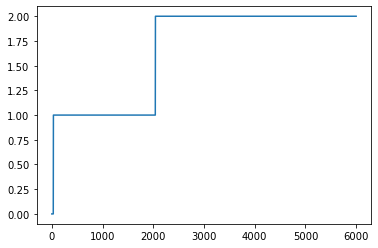

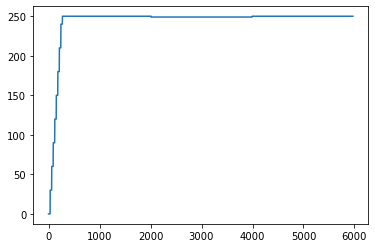

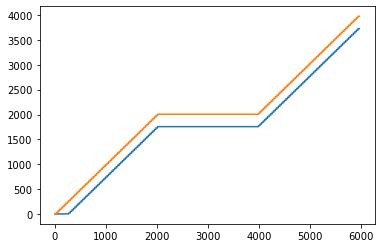

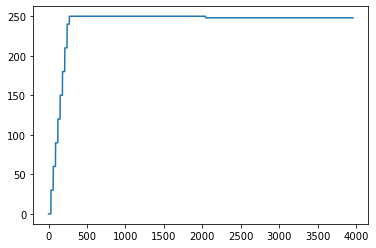

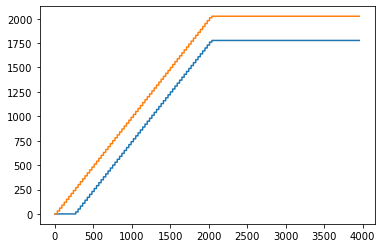

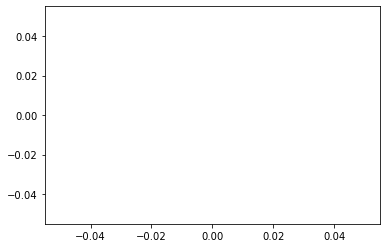

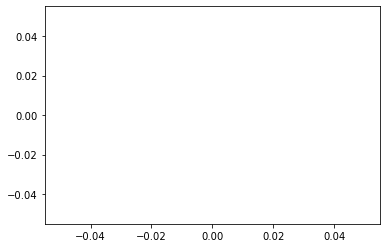

TP: 3827 TN: 61 FP: 117 FN: 1905
ACC: 0.6578680203045685 Precision: 0.9703346855983773 Recall: 0.6676552686671319 F1: 0.7910293509714759
FPR: 62.0 TPR: 1906.0
**********
window_size: 30
t: 10
phi: 15
thresh: 0.6
Add new detector because feature drift
Add new detector because concept drift
scores [-1.]


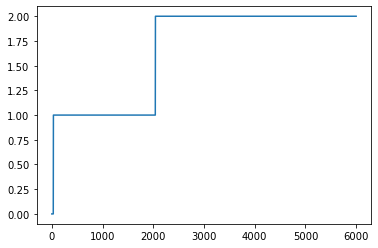

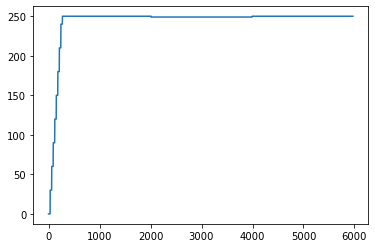

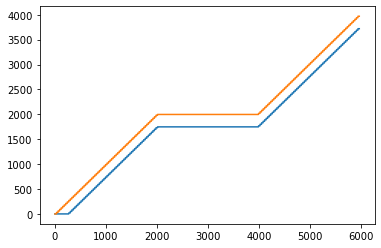

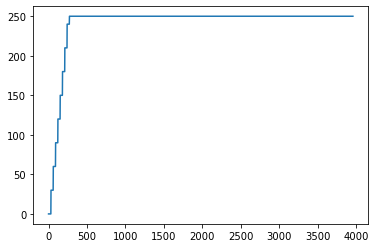

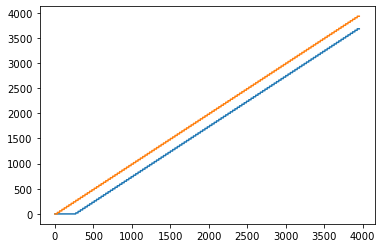

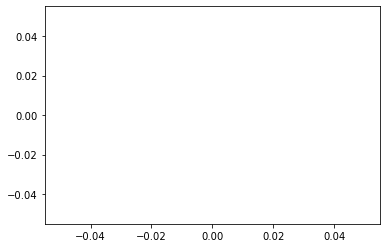

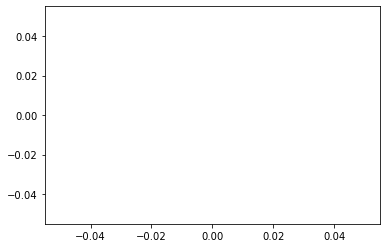

TP: 5458 TN: 8 FP: 170 FN: 274
ACC: 0.9248730964467005 Precision: 0.9697938877043355 Recall: 0.9521981856245638 F1: 0.9609154929577465
FPR: 9.0 TPR: 275.0
**********
window_size: 30
t: 10
phi: 15
thresh: 0.7
Add new detector because feature drift
Add new detector because concept drift
scores [-1.]


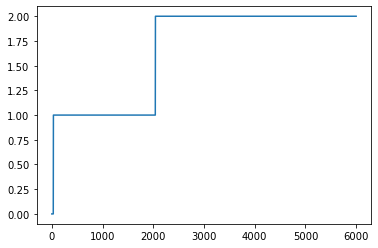

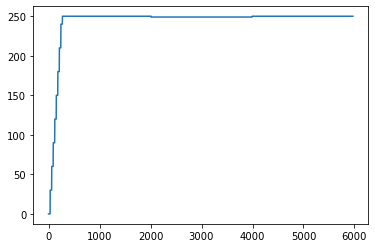

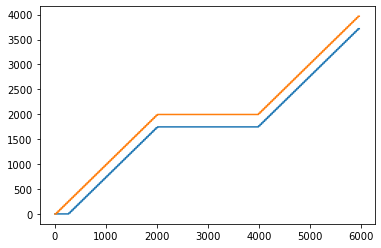

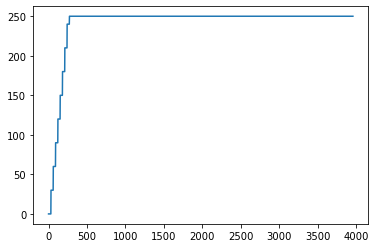

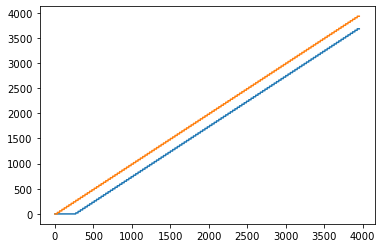

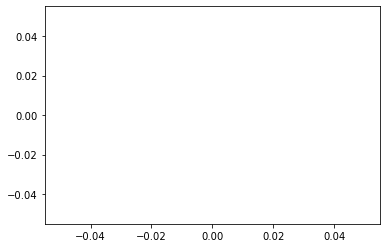

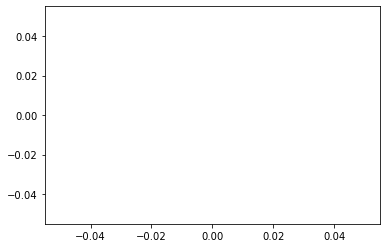

TP: 5646 TN: 2 FP: 176 FN: 86
ACC: 0.955668358714044 Precision: 0.9697698385434559 Recall: 0.984996510816469 F1: 0.9773238705210318
FPR: 3.0 TPR: 87.0
**********
window_size: 30
t: 10
phi: 27
thresh: 0.5
Add new detector because feature drift
Add new detector because concept drift
scores [-1.]


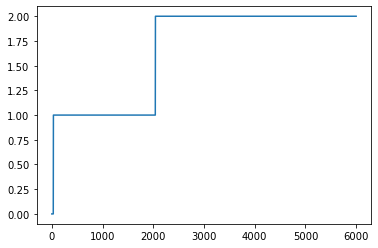

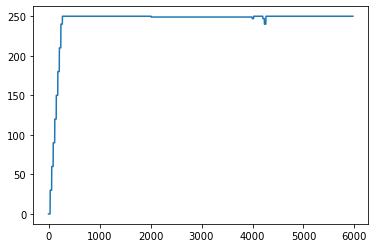

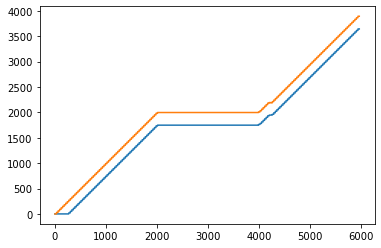

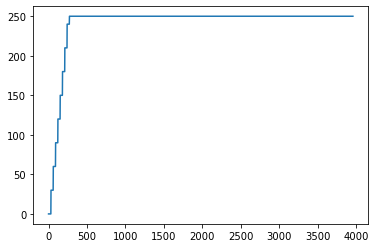

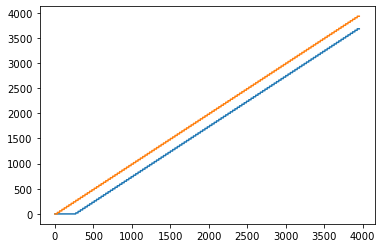

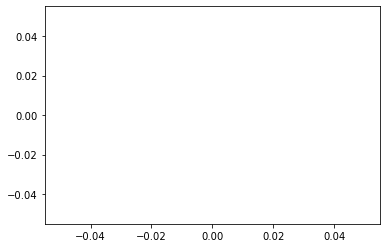

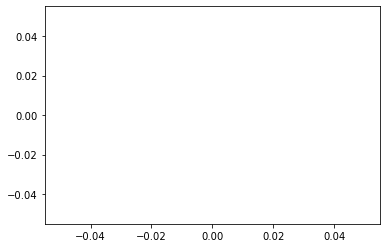

TP: 2508 TN: 98 FP: 80 FN: 3224
ACC: 0.44094754653130286 Precision: 0.9690880989180835 Recall: 0.43754361479413817 F1: 0.6028846153846154
FPR: 99.0 TPR: 3225.0
**********
window_size: 30
t: 10
phi: 27
thresh: 0.6
Add new detector because feature drift
Add new detector because concept drift
scores [-1.]


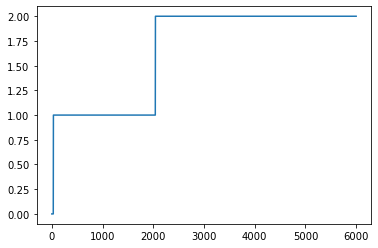

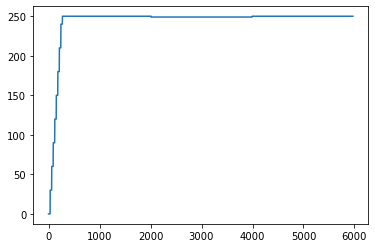

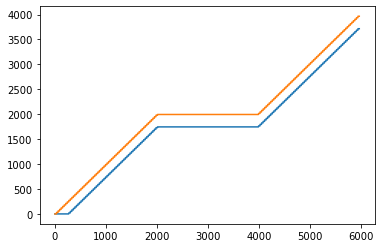

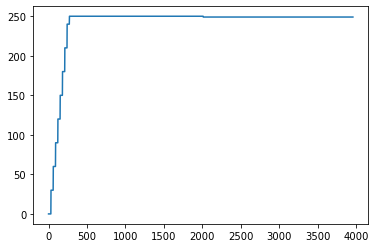

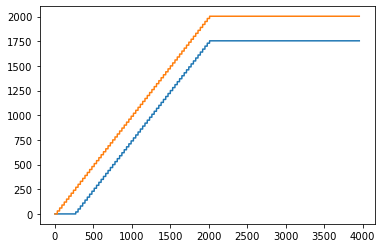

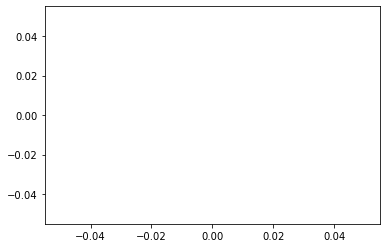

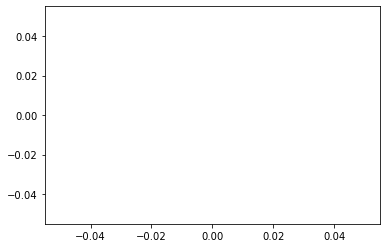

TP: 5381 TN: 10 FP: 168 FN: 351
ACC: 0.9121827411167512 Precision: 0.9697242746440801 Recall: 0.938764829030007 F1: 0.9539934402978459
FPR: 11.0 TPR: 352.0
**********
window_size: 30
t: 10
phi: 27
thresh: 0.7
Add new detector because feature drift
Add new detector because concept drift
scores [-1.]
Add new detector because concept drift
scores [-1. -1.]


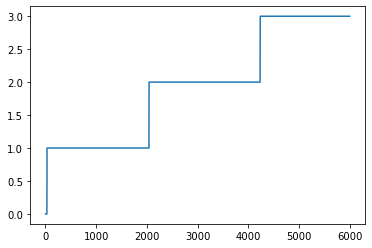

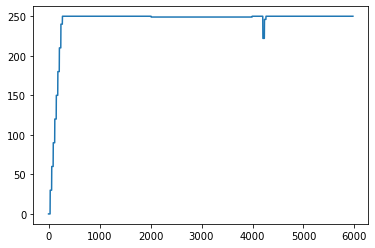

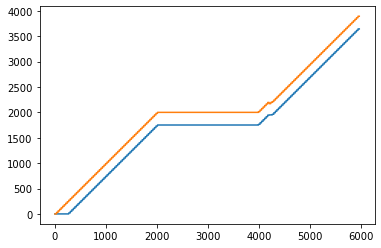

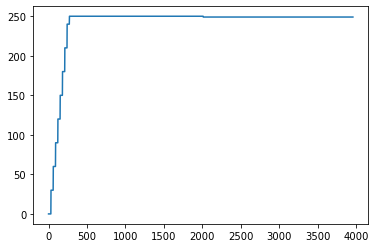

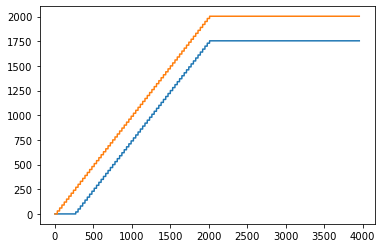

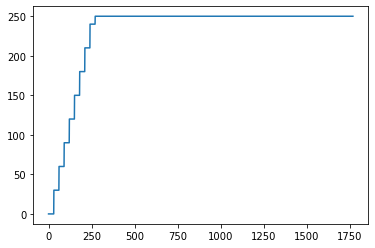

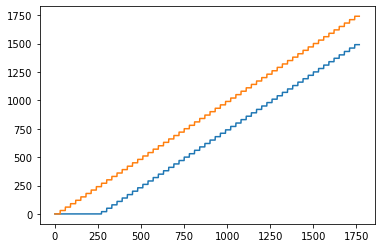

TP: 5620 TN: 4 FP: 174 FN: 82
ACC: 0.9564625850340136 Precision: 0.969968933379358 Recall: 0.985619081024202 F1: 0.977731384829506
FPR: 5.0 TPR: 83.0
**********
window_size: 30
t: 30
phi: 15
thresh: 0.5
Add new detector because feature drift
Add new detector because concept drift
scores [-1.]


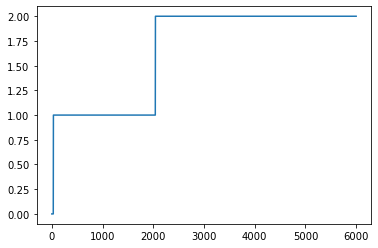

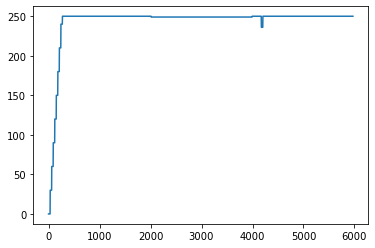

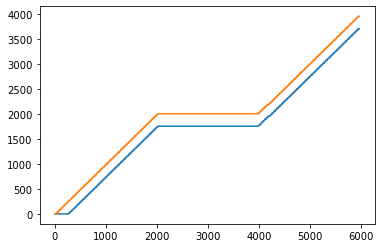

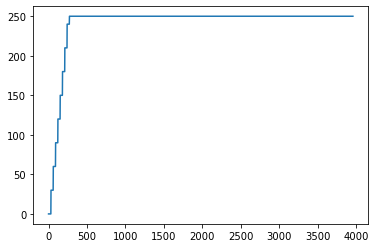

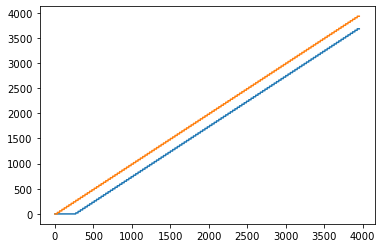

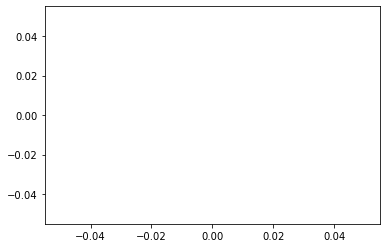

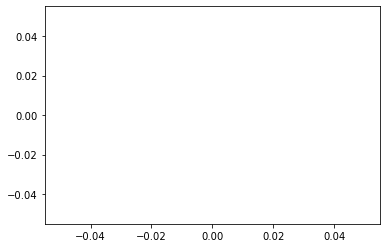

TP: 2426 TN: 108 FP: 70 FN: 3306
ACC: 0.4287648054145516 Precision: 0.9719551282051282 Recall: 0.4232379623168179 F1: 0.5896937287311619
FPR: 109.0 TPR: 3307.0
**********
window_size: 30
t: 30
phi: 15
thresh: 0.6
Add new detector because feature drift
Add new detector because concept drift
scores [-1.]


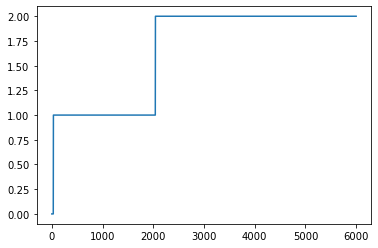

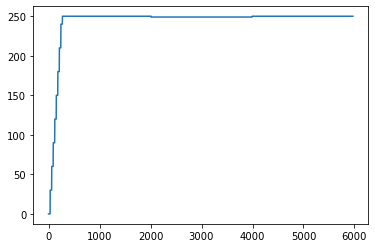

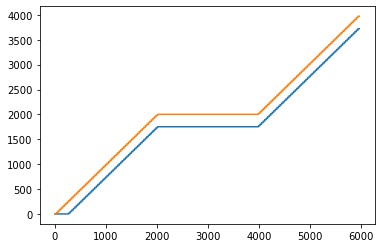

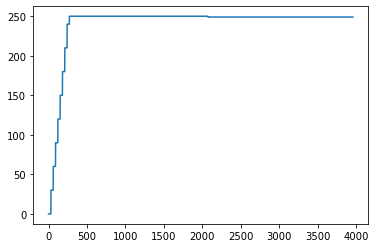

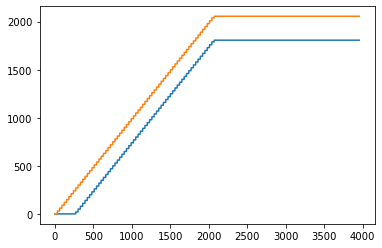

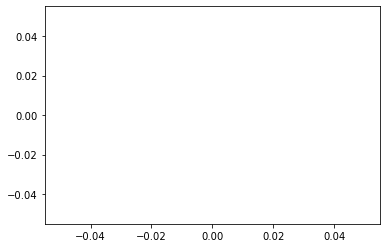

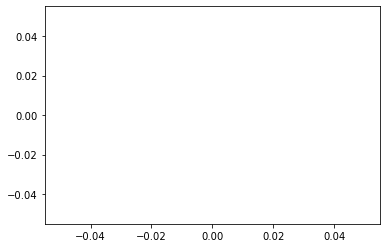

TP: 5530 TN: 6 FP: 172 FN: 202
ACC: 0.9367174280879864 Precision: 0.9698351455629604 Recall: 0.9647592463363573 F1: 0.9672905369949274
FPR: 7.0 TPR: 203.0
**********
window_size: 30
t: 30
phi: 15
thresh: 0.7
Add new detector because feature drift


KeyboardInterrupt: 

In [174]:
window_size_list = list(range(10,1000,50))
t_list = list(range(10,100,20))
phi_list = list(range(int(window_size/10),window_size,int(window_size/10)))
thresh_list = [0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75]

window_size_list = [30,50]
t_list = [10,30]
phi_list = [0.5,0.9]
thresh_list = [0.5,0.6,0.7]

results = np.zeros((len(window_size_list),len(t_list),len(phi_list),len(thresh_list),10))

for aa in range(len(window_size_list)):
    window_size = window_size_list[aa]
    for bb in range(len(t_list)):
        t = t_list[bb]
        for cc in range(len(phi_list)):
            phi = int(phi_list[cc]*window_size)
            for dd in range(len(thresh_list)):
                thresh = thresh_list[dd]

                madwin_len = [[],[],[]]

                max_i = [[],[],[]]
                min_i = [[],[],[]]
                
                print('*'*10)
                print('window_size:',window_size)
                print('t:',t)
                print('phi:',phi)
                print('thresh:',thresh)
                detector = algorithm(e=10,
                                     window_size=window_size,
                                     t=t,
                                     phi=phi,
                                     delta=0.02,
                                     min_win_size=5,
                                     thresh=thresh)
                prediction = []
                scores = []
                e_num = []
                for i in range(len(stream)):
                    x = stream[i]
                    output,var = detector.predict(x)
                    prediction += output
                    e_num.append(len(detector.ensemble))
                    print(i,end='\r')
                    for e in range(len(detector.ensemble)):
                        madwin_len[e].append(len(detector.ensemble[e].madwin.W))
                        max_i[e].append(detector.ensemble[e].madwin.max_i)
                        min_i[e].append(detector.ensemble[e].madwin.min_i)
#                 print(results[aa,bb,cc,dd])
                plt.figure()
                plt.plot(e_num)
                plt.show()
                for i in range(len(madwin_len)):
                    plt.figure()
                    plt.plot(madwin_len[i])
                    plt.show()
                    plt.figure()
                    plt.plot(min_i[i])
                    plt.plot(max_i[i])
                    plt.show()
                    
                
                res = evaluation(prediction,label[:len(prediction)])
                results[aa,bb,cc,dd] = res
#                 print(results[aa,bb,cc,dd])

[0. 0.]


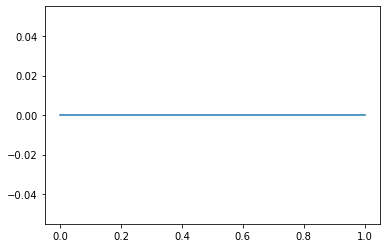

In [25]:
# plt.figure()
result = results[1,1,1,:,7]
plt.plot(result)
print(result)
plt.show()

In [83]:
evaluation(prediction,label[:len(prediction)])

TP: 1082 TN: 23 FP: 29 FN: 666
ACC: 0.6138888888888889 Precision: 0.9738973897389739 Recall: 0.6189931350114416 F1: 0.7569080097936342
FPR: 0.5660377358490566 TPR: 0.6192109777015438


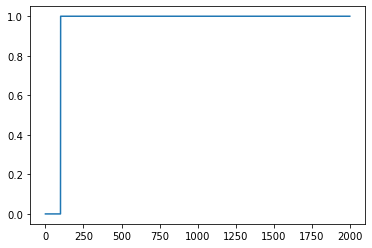

In [75]:
plt.figure()
plt.plot(e)
plt.show()

500 0
500 1
500 1
1500 1


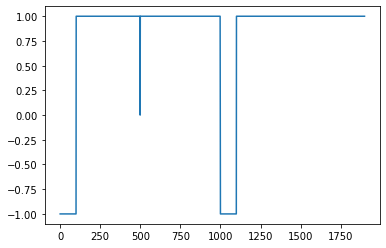

In [178]:
print('500',prediction[499])
print('500',prediction[500])
print('500',prediction[502])
print('1500',prediction[1500])
plt.figure()
plt.plot(prediction)
plt.show()

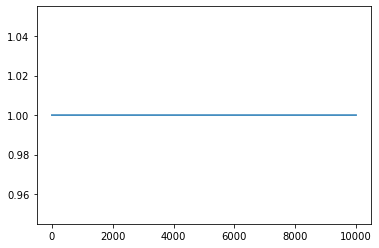

In [74]:
plt.figure()
plt.plot(label)
plt.show()

In [13]:
def stream_generator(normal,abnormal,n):
    normal_data_folder = normal
    abnormal_data_folder = abnormal
    normal_file_list = []
    abnormal_file_list = []
    for f in os.listdir(normal_data_folder):
        normal_file_list.append(normal_data_folder+f)
    for f in os.listdir(abnormal_data_folder):
        abnormal_file_list.append(abnormal_data_folder+f)
    stream_list = []
    label_list = []
    connection_list = []

    feature = ['Agent','ProcessName','TaskID','Label','Title','Host','HRT','Operation','Source','ThreadID','EventID','ProcessID']

    for i in range(n):
    
        cati = {}
        for i in range(12):
            cati[i] = []
        normal_file = random.sample(normal_file_list,1)
        abnormal_file = random.sample(abnormal_file_list,1)
#         stream_file = normal_file[1:] + abnormal_file
#         random.shuffle(stream_file)
#         stream_file = [normal_file[0]]+stream_file
        stream_file = normal_file + abnormal_file+ abnormal_file+ abnormal_file+ abnormal_file
#         print(stream_file)
        
    
        cati = {}
        for i in range(12):
            cati[feature[i]] = []
            
        stream = []
        labels = []
        connection = []
        for f in stream_file:
            if f[:len(abnormal_data_folder)]==abnormal_data_folder:
                label = 0
            else:
                label = 1
            with open(f, "r") as read_file:
                data = json.load(read_file)
            report_list = data[0]['reports']
            number_of_events = len(report_list)
            print(number_of_events)
            s = []
            l = []
            for i in range(number_of_events):
                event = [0]*12
                for j in range(12):
                    e = report_list[i].get(feature[j])
                    if e not in cati[feature[j]]:
                        cati[feature[j]].append(e)
                    event[j] = cati[feature[j]].index(e) 
                l.append(label)
                s.append(event)
#             connection.append(len(stream))
            l = np.array(l)
            s = np.array(s)
            p = np.random.permutation(len(l))
#             print(s[:10])
#             l = l[p]
#             s = s[p]
#             print(s[:10])
            if len(stream)>0:
                stream = np.concatenate((stream,s),axis=0)
                labels = np.concatenate((labels,l),axis=0)
            else:
                stream = s
                labels = l
#             print(len(l))
#             print(len(s))
#             break
#         break
#         p = np.random.permutation(len(stream))
#         stream = stream[p]
#         labels = labels[p]
        stream_list.append(stream)
        label_list.append(labels)
        connection_list.append(connection)
    
        
    return stream_list,label_list,connection_list,cati

In [14]:
def evaluation(detector,label):
    TP=0
    TN=0
    FP=0
    FN=0
    for i in range(len(label)):
        if detector.prediction[i] != -1:
            if detector.prediction[i] and label[i]:
                TP += 1
            elif detector.prediction[i] and not label[i]:
                FP += 1
            elif not detector.prediction[i] and label[i]:
                FN += 1
            else:
                TN += 1
    ACC = (TP+TN)/(TP+TN+FP+FN)
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1 = 2*Precision*Recall/(Precision+Recall)
    FPR = (FP+1)/(FP+TN+1)
    TPR = (TP+1)/(TP+FN+1)
    print('TP:',TP,'TN:',TN,'FP:',FP,'FN:',FN)
    print('ACC:',ACC,'Precision:',Precision,'Recall:',Recall,'F1:',F1)
    print('FPR:',FPR,'TPR:',TPR)
    return

In [15]:
dataset = ['raw_data/shuttle.txt',
           'raw_data/smtp.txt',
           'raw_data/pima.txt',
           'raw_data/satellite.txt',
           'raw_data/smtp_http.txt',
           'raw_data/shuttle.txt',
           'raw_data/shuttle.txt']

In [70]:
a = np.loadtxt(dataset[1])
stream = a[:10000,:-1]
label = a[:10000,-1]
label = 1-label
print(stream.shape)

(10000, 3)


In [179]:
a = np.loadtxt(dataset[1])
stream = a[:,:-1]
label = a[:,-1]
label = 1-label
print(stream.shape)

(95156, 3)


In [28]:
X = stream[:100]
selector = VarianceThreshold()
Xp = selector.fit_transform(X)


In [31]:
X = []
for x in stream[:100]:
    X.append(x)
selector = VarianceThreshold()
Xp = selector.fit_transform(X)
print(Xp.shape)

(100, 8)


In [17]:
a = np.loadtxt(dataset[2])
stream = a[:,:-1]
label = a[:,-1]
label = 1-label

In [18]:
print(stream.shape)
print(label.shape)

(768, 8)
(768,)


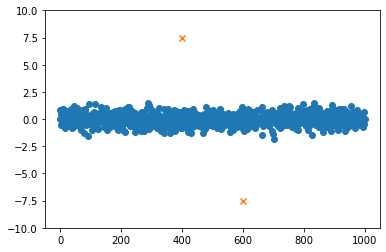

In [13]:
mean = [0,10,40,30]
var = [.5,.5,.5,.5]
X = np.array([])
for i in range(1):
    X = np.concatenate((X,np.random.normal(mean[i],var[i],1000)),axis=0)
    
plt.figure()
plt.scatter(range(len(X)),X)
plt.scatter([400,600],[7.5,-7.5],marker='x')
plt.ylim(-10,10)
plt.show()

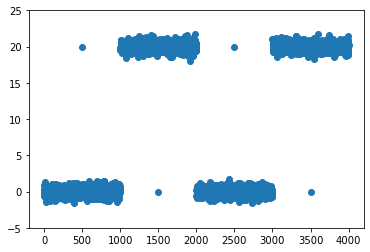

(4000, 1)


In [98]:
mean = [0,20,0,20]
var = [.5,.5,.5,.5]
X = np.array([])
for i in range(4):
    X = np.concatenate((X,np.random.normal(mean[i],var[i],1000)),axis=0)

X[500]=20
X[1500]=0
X[2500]=20
X[3500]=0
    
plt.figure()
plt.scatter(range(len(X)),X)
plt.ylim(-5,25)
plt.show()
stream = X.reshape((-1,1))
print(stream.shape)

(100,)


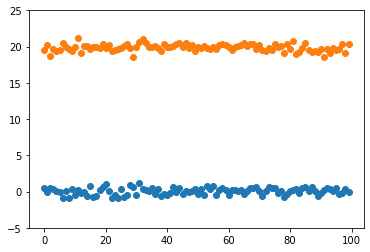

(200,)


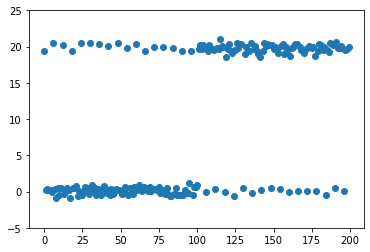

In [17]:
mean = [0,20,0,20]
var = [.5,.5,.5,.5]
X1 = np.array([])
X2 = np.array([])
X1 = np.concatenate((X1,np.random.normal(mean[0],var[0],100)),axis=0)
X2 = np.concatenate((X2,np.random.normal(mean[1],var[1],100)),axis=0)
X3,l = random_mix(X1,X2,100,(5,1))
X4,l = random_mix(X2,X1,100,(5,1))

print(X3.shape)
plt.figure()
plt.scatter(range(len(X1)),X1)
plt.scatter(range(len(X2)),X2)
plt.ylim(-5,25)
plt.show()

stream = np.concatenate((X3,X4),axis=0)
print(stream.shape)
plt.figure()
plt.scatter(range(len(stream)),stream)
plt.ylim(-5,25)
plt.show()

In [8]:
def random_mix(a,b,l,p):
    '''
    a: first stream
    b: second stream
    l: length of output stream
    p: mix persantage of two stream
    
    output:
    stream: mix stream
    label: label of mix stream
    '''
    pa,pb = p
    na = int(pa/(pa+pb)*l)
    nb = int(pb/(pa+pb)*l)
    sa = random.choices(a,k=na+1)
    sb = random.choices(b,k=nb+1)
#     print('na,nb',na,nb)
    stream = []
    label = []
    ai = 0
    bi = 0
    for i in range(l):
#         print(i,ai,bi)
        event = None
        if i%(pa+pb) == 0:
            stream.append(sb[bi])
            label.append(0)
            bi += 1
        else:
            stream.append(sa[ai])
            label.append(1)
            ai += 1
    return np.array(stream),np.array(label)

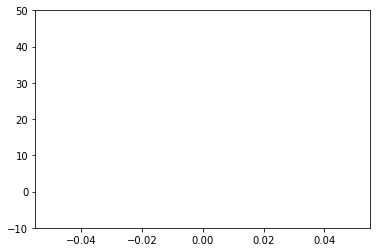

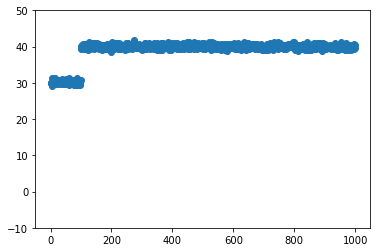

In [132]:
mean = [0,20,40,30]
var = [.5,.5,.5,.5]
normal = np.array([])
abnormal = np.array([])
# for i in range(1):
normal1 = np.concatenate((normal,np.random.normal(mean[0],var[0],1000)),axis=0)
normal2 = np.concatenate((normal,np.random.normal(mean[1],var[1],1000)),axis=0)
abnormal = np.concatenate((abnormal,np.random.normal(mean[2],var[2],1000)),axis=0)
abnormal[:100] = np.random.normal(mean[3],var[3],100)
plt.figure()
plt.scatter(range(len(normal)),normal)
plt.ylim(-10,50)
plt.show()
plt.figure()
plt.scatter(range(len(abnormal)),abnormal)
plt.ylim(-10,50)
plt.show()
stream1,label1 = random_mix(normal1,abnormal,1000,(1,1))
stream2,label2 = random_mix(normal2,abnormal,1000,(1,1))
stream = np.concatenate((stream1,stream2),axis=0)
label = np.concatenate((label1,label2),axis=0)
# stream = np.concatenate((np.random.normal(mean[0],var[0],100),stream),axis=0)
# label = np.concatenate((np.ones((100,)),label),axis=0)

2000
[ True]


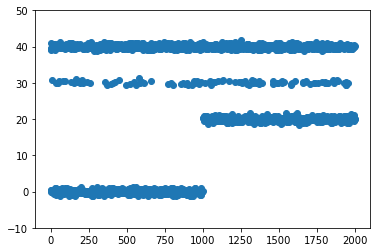

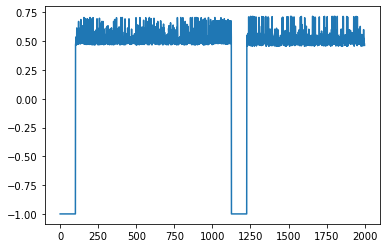

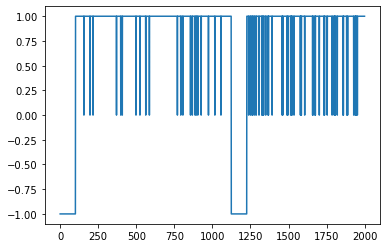

TP: 899 TN: 71 FP: 827 FN: 0
ACC: 0.5397885364496383 Precision: 0.5208574739281576 Recall: 1.0 F1: 0.684952380952381
FPR: 0.9210233592880979 TPR: 1.0


In [135]:
# X.reshape(-1,1)
stream = stream.reshape(-1,1)
detector = iForestADWIN(100,1000,50,None,thresh=0.7,text=False,delta=0.02)
print(len(stream))
for i in range(len(stream)):
    detector.add_element(stream[i])
#     if i >=200:
#         print("********",stream[i],detector.score[i])
    print(i,end='\r')
print(detector.feature_filter)
plt.figure()
plt.scatter(range(len(stream)),stream)
plt.ylim(-10,50)
plt.show()
plt.figure()
plt.plot(detector.score)
plt.show()
plt.figure()
plt.plot(detector.prediction)
# plt.plot(label_list[j])
plt.show()
evaluation(detector,label)


1000
[ True]


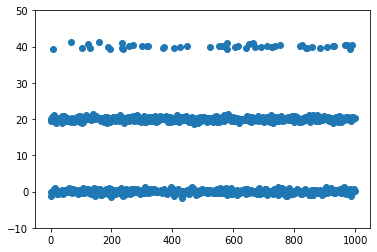

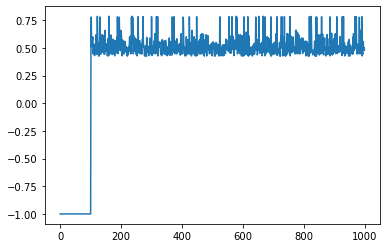

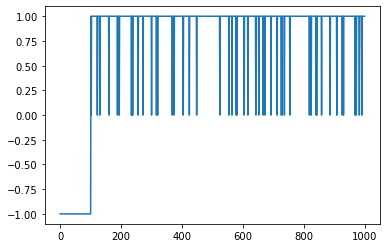

TP: 450 TN: 49 FP: 400 FN: 0
ACC: 0.5550611790878754 Precision: 0.5294117647058824 Recall: 1.0 F1: 0.6923076923076924
FPR: 0.8911111111111111 TPR: 1.0


In [114]:
# X.reshape(-1,1)
stream = stream.reshape(-1,1)
detector = iForestADWIN(100,1000,50,None,thresh=0.7,text=False,delta=0.02)
print(len(stream))
for i in range(len(stream)):
    detector.add_element(stream[i])
#     if i >=200:
#         print("********",stream[i],detector.score[i])
    print(i,end='\r')
print(detector.feature_filter)
plt.figure()
plt.scatter(range(len(stream)),stream)
plt.ylim(-10,50)
plt.show()
plt.figure()
plt.plot(detector.score)
plt.show()
plt.figure()
plt.plot(detector.prediction)
# plt.plot(label_list[j])
plt.show()
evaluation


In [88]:
def evaluation(detector,label):
    TP=0
    TN=0
    FP=0
    FN=0
    for i in range(len(label)):
        if detector.prediction[i] != -1:
            if detector.prediction[i] and label[i]:
                TP += 1
            elif detector.prediction[i] and not label[i]:
                FP += 1
            elif not detector.prediction[i] and label[i]:
                FN += 1
            else:
                TN += 1
    ACC = (TP+TN)/(TP+TN+FP+FN)
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1 = 2*Precision*Recall/(Precision+Recall)
    FPR = (FP+1)/(FP+TN+1)
    TPR = (TP+1)/(TP+FN+1)
    print('TP:',TP,'TN:',TN,'FP:',FP,'FN:',FN)
    print('ACC:',ACC,'Precision:',Precision,'Recall:',Recall,'F1:',F1)
    print('FPR:',FPR,'TPR:',TPR)
    return

In [ ]:


# X.reshape(-1,1)
stream = X.reshape(-1,1)
for i in range(100):
    for j in range(i+1):
        detector = iForestADWIN(i,1000,j,None,thresh=0.7,text=False,delta=0.02)
        print(len(stream))
        for i in range(len(stream)):
            detector.add_element(stream[i])
        #     if i >=200:
        #         print("********",stream[i],detector.score[i])
            print(i,end='\r')
        print(detector.feature_filter)
        plt.figure()
        plt.scatter(range(len(X)),X)
        plt.ylim(-10,50)
        plt.show()
        plt.figure()
        plt.plot(detector.score)
        plt.show()
        plt.figure()
        plt.plot(detector.prediction)
        # plt.plot(label_list[j])
        plt.show()
        print(detector.score[206],detector.score[202],detector.score[800])
        print(detector.prediction[206],detector.prediction[202],detector.prediction[800])